## Init notebook

This is run once.

## Preliminaries

In [1]:
import quantus

2023-09-29 14:43:45.166569: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-29 14:43:45.957809: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/lweber/work-code/Quantus/quantus/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:


# Import libraries.
from IPython.display import clear_output
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import warnings
import torch
import captum
import torchvision
import matplotlib.cm as cm
import gc
import os
from tqdm import tqdm

from zennit import attribution as zattr
from zennit import image as zimage
from zennit import composites as zcomp

from models import models
from data import dataloaders, datasets, transforms
from attribution import zennit_utils as zutils
from utils import arguments as argument_utils
from main import *

try:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print('Using device:', torch.cuda.get_device_name(0))
except:
    pass

/home/lweber/work-code/Quantus/eMPRT/scripts/quantus/__init__.py
Using device: NVIDIA TITAN RTX


In [3]:
# Plot Parameters
import matplotlib as mpl
import matplotlib.font_manager as font_manager
mpl.rcParams['font.family']='serif'
cmfont = font_manager.FontProperties(fname=mpl.get_data_path() + '/fonts/ttf/cmr10.ttf')
mpl.rcParams['font.serif']=cmfont.get_name()
mpl.rcParams['mathtext.fontset']='cm'
mpl.rcParams['axes.unicode_minus']=False
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 15})

In [4]:
def smoothexplain(model, inputs, targets, **kwargs):

    xai_noiselevel = kwargs.pop("xai_noiselevel", 0.1)
    xai_n_noisedraws = kwargs.pop("xai_n_noisedraws", 1)
    
    device = kwargs.get("device", None)
    if not isinstance(inputs, torch.Tensor):
        inputs = torch.Tensor(inputs).to(device)

    if not isinstance(targets, torch.Tensor):
        targets = torch.as_tensor(targets).to(device)

    dims = tuple(range(1, inputs.ndim))
    std = xai_noiselevel / (inputs.amax(dims, keepdim=True) - inputs.amin(dims, keepdim=True))

    result = np.zeros(inputs.shape)
    for n in range(xai_n_noisedraws):
        # the last epsilon is defined as zero to compute the true output,
        # and have SmoothGrad w/ n_iter = 1 === gradient
        if n == xai_n_noisedraws - 1:
            epsilon = torch.zeros_like(inputs)
        else:
            epsilon = torch.randn_like(inputs) * std
            
        expl = quantus.explain(model, inputs + epsilon, targets, **kwargs)
        result += expl / xai_n_noisedraws

    return result

def plot_heatmap(attr, dst, cmap="seismic", level=2.0):
    """
    Plots a single heatmaps from src .npy file, and
    """

    # Preprocess attributions
    amax = np.abs(attr).max((1, 2), keepdims=True)
    attr = (attr + amax) / 2 / amax


    # Render and save image
    img = zimage.imsave(
        dst,
        attr,
        vmin=0,
        vmax=1.,
        level=level,
        cmap=cmap
    )

    # plt.imshow(img)
    # plt.axis("off")
    # plt.margins(0,0)

    # plt.show()


def plot_input(img, dst, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    """
    Plots a single input image from src .npy file, and saves it to dst as a .png
    """

    # TODO: Preprocess?
    img = img.transpose(1, 2, 0)
    img *= std
    img += mean
    img = img*255
    img = np.uint8(img)

    # Render and save image
    img = Image.fromarray(img, mode="RGB")
    img.save(dst)
    img = np.asarray(img)
    plt.imshow(img)
    plt.axis("off")
    plt.margins(0,0)
    plt.show()

## Experiment



Preparing datasets...
DATA_ROOT /media/lweber/f3ed2aae-a7bf-4a55-b50d-ea8fb534f1f5/Datasets/imagenet/val
Number of Samples in Dataset: 1000
Reduced of Samples in Dataset: 50
Preparing dataloaders...


/home/lweber/work-code/Quantus/quantus/venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/lweber/work-code/Quantus/quantus/venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_3154694/3749630740.py:73: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.imshow(img)


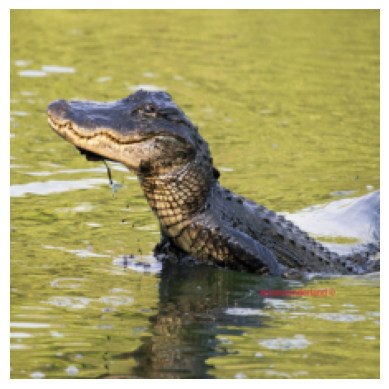

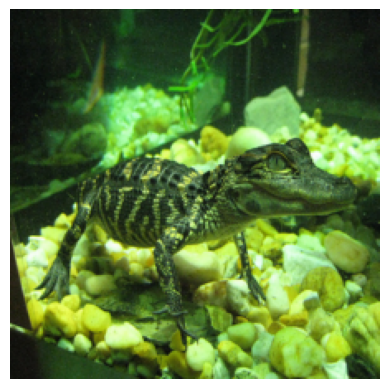

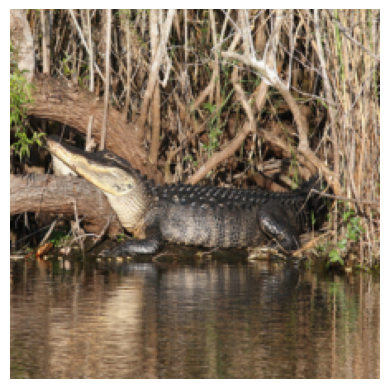

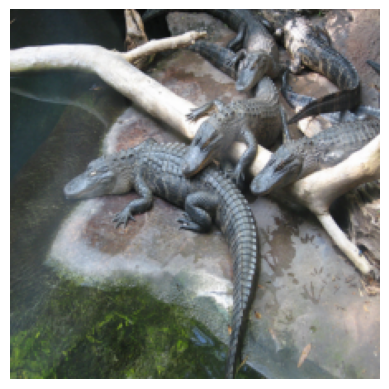

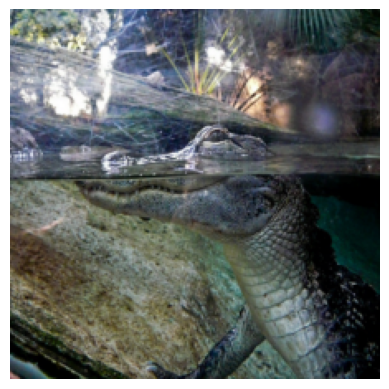

In [5]:
# Load data.
dataset_name = "imagenet"
model_name = "vgg16"
nr_test_samples = 50
num_classes = 1000
data_path = "/media/lweber/f3ed2aae-a7bf-4a55-b50d-ea8fb534f1f5/Datasets/imagenet"
labelmap_path = "label_map_imagenet.json"
image_path = "/media/lweber/f3ed2aae-a7bf-4a55-b50d-ea8fb534f1f5/mptc/figures/raw_heatmaps"
os.makedirs(image_path, exist_ok=True)

# Get Dataset
# Prepare transforms
transform = transforms.get_transforms(dataset_name, mode="test")

# Prepare datasets
print("Preparing datasets...")
dataset = datasets.get_dataset(
    dataset_name,
    data_path,
    transform,
    mode="test",
    labelmap_path=labelmap_path
)

print(f"Number of Samples in Dataset: {len(dataset.samples)}")
dataset.samples = dataset.samples[:nr_test_samples]
print(f"Reduced of Samples in Dataset: {len(dataset.samples)}")

# Prepare dataloaders
print("Preparing dataloaders...")
loader = dataloaders.get_dataloader(
    dataset_name = dataset_name,
    dataset = dataset,
    batch_size = 5,
    shuffle = False,
)
# Prepare model
model = models.get_model(model_name, device)
model.eval()

for i, (batch, labels) in enumerate(loader):

    x_batch = batch.numpy()
    y_batch = labels.numpy()

    img_size = x_batch.shape[2]
    nr_channels = x_batch.shape[1]

    # Plot the data!
    for i in range(5):
        plot_input(x_batch[i], os.path.join(image_path, f"inp_{i}.png"))

    break

In [6]:
XAI_METHOD_KWARGS = {
        "lrp-zplus": {
            "xai_lib": "zennit",
            "attributor": zattr.Gradient,
            "composite": zutils.ZPlus,
            "canonizer": zutils.get_zennit_canonizer(model),
            "canonizer_kwargs": {},
            "composite_kwargs": {
                "stabilizer": 1e-6,
            },
            "device": device,
        },
        "gradient": {
            "xai_lib": "zennit",
            "attributor": zattr.Gradient,
            "canonizer": None,
            "composite": None,
            "canonizer_kwargs": {},
            "composite_kwargs": {},
            "device": device,
        },
        "lrp-epsilon": {
            "xai_lib": "zennit",
            "attributor": zattr.Gradient,
            "composite": zutils.Epsilon,
            "canonizer": zutils.get_zennit_canonizer(model),
            "canonizer_kwargs": {},
            "composite_kwargs": {
                "stabilizer": 1e-6,
                "epsilon": 1e-6
            },
            "device": device,
        },
        "guided-backprop": {
            "xai_lib": "zennit",
            "attributor": zattr.Gradient,
            "canonizer": None,
            "composite": zcomp.GuidedBackprop,
            "canonizer_kwargs": {},
            "composite_kwargs": {},
            "device": device,
        },
        "grad-cam" : {
            "xai_lib": "captum",
            "device": device,
            "gc_layer": eval("model.features[-2]") if model_name == "vgg16" else eval("list(model.named_modules())[61][1]"),
            "interpolate": (img_size, img_size),
            "interpolate_mode": "bilinear",
            "method": "LayerGradCam",
        },
        "gradient-noabs": {
            "xai_lib": "zennit",
            "attributor": zattr.Gradient,
            "canonizer": None,
            "composite": None,
            "canonizer_kwargs": {},
            "composite_kwargs": {},
            "device": device,
        },
        "smoothgrad": {
            "xai_lib": "zennit",
            "attributor": zattr.SmoothGrad,
            "attributor_kwargs": {
                "n_iter": 20,
                "noise_level": 0.1
            },
            "canonizer": None,
            "composite": None,
            "canonizer_kwargs": {},
            "composite_kwargs": {},
            "device": device,
        },
        "intgrad": {
            "xai_lib": "zennit",
            "attributor": zattr.IntegratedGradients,
            "attributor_kwargs": {
                "n_iter": 20,
            },
            "canonizer": None,
            "composite": None,
            "canonizer_kwargs": {},
            "composite_kwargs": {},
            "device": device,
        },
    }


### Normal Explanations

In [7]:
xai_method = "lrp-epsilon"

explanations = quantus.explain(
    model=model,
    inputs=x_batch,
    targets=y_batch,
    **XAI_METHOD_KWARGS[xai_method],
)

for i, e in enumerate(explanations):
    if i <= 1:
        plot_heatmap(e, os.path.join(image_path, f"hm_{i}.png"), cmap="seismic", level=2.0)

/home/lweber/work-code/Quantus/eMPRT/scripts/quantus/functions/explanation_func.py:117: UserWarning: Using quantus 'explain' function as an explainer without specifying 'method' (string) in kwargs will produce a vanilla 'Gradient' explanation.

  warnings.warn(


### Abs Explanations

In [8]:
xai_method = "lrp-epsilon"

explanations = quantus.explain(
    model=model,
    inputs=x_batch,
    targets=y_batch,
    **XAI_METHOD_KWARGS[xai_method],
)

for i, e in enumerate(explanations):
    if i <= 5:
        plot_heatmap(np.abs(e),  os.path.join(image_path, f"hm_abs_{i}.png"),cmap="seismic", level=2.0)

### Noise Explanations

In [15]:
xai_method = "guided-backprop"

explanations = quantus.explain(
    model=model,
    inputs=x_batch,
    targets=y_batch,
    **XAI_METHOD_KWARGS[xai_method],
)

for i, e in enumerate(explanations):
    if i <= 5:
        plot_heatmap(np.random.uniform(low=-1, high=1, size=e.shape), os.path.join(image_path, f"hm_noise_{i}.png"), cmap="seismic", level=1.0)

### "Denoised" Explanations

In [10]:
xai_method = "lrp-epsilon"

explanations = smoothexplain(
    model=model,
    inputs=x_batch,
    targets=y_batch,
    **XAI_METHOD_KWARGS[xai_method],
    xai_noiselevel = 0.2,
    xai_n_noisedraws = 100,
)

for i, e in enumerate(explanations):
    if i <= 5:
        plot_heatmap(np.expand_dims(e[0], 0), os.path.join(image_path, f"hm_den2_{i}.png"), cmap="seismic", level=2.0)

### Randomised Model

In [19]:
n_layers = len(list(get_random_layer_generator(model, order="bottom_up")))
model_iterator = tqdm(
    get_random_layer_generator(model, order="bottom_up"),
    total=n_layers,
    disable=True,
)

for l_ix, (layer_name, random_layer_model) in enumerate(model_iterator):

    if l_ix == 10:
        break

In [20]:
xai_method = "lrp-epsilon"

explanations = quantus.explain(
    model=random_layer_model,
    inputs=x_batch,
    targets=y_batch,
    **XAI_METHOD_KWARGS[xai_method],
)

for i, e in enumerate(explanations):
    if i <= 0:
        plot_heatmap(e, os.path.join(image_path, f"hm_randmod_{i}.png"), cmap="seismic", level=2.0)

In [21]:
xai_method = "lrp-epsilon"

explanations = smoothexplain(
    model=random_layer_model,
    inputs=x_batch,
    targets=y_batch,
    **XAI_METHOD_KWARGS[xai_method],
    xai_noiselevel = 0.2,
    xai_n_noisedraws = 100,
)

for i, e in enumerate(explanations):
    if i <= 0:
        plot_heatmap(np.expand_dims(e[0], 0), os.path.join(image_path, f"hm_randmod_den2_{i}.png"), cmap="seismic", level=2.0)

### sMPRT explanations

/tmp/ipykernel_3154694/3749630740.py:73: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.imshow(img)


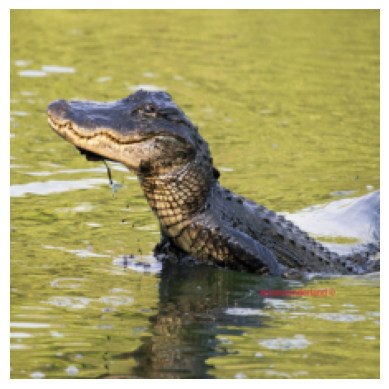

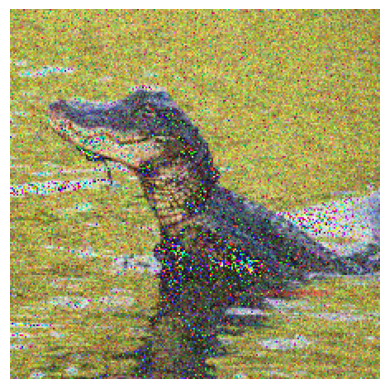

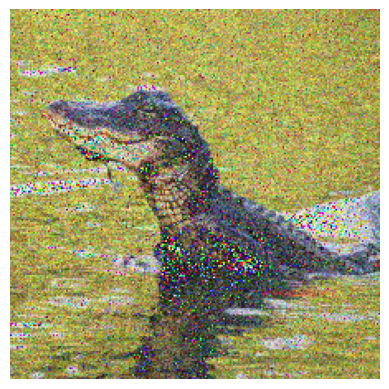

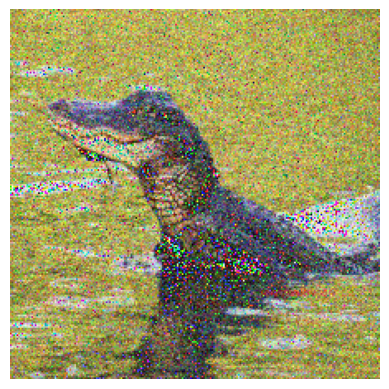

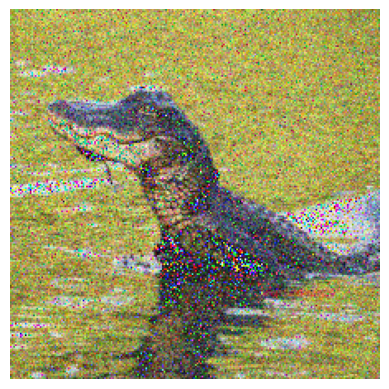

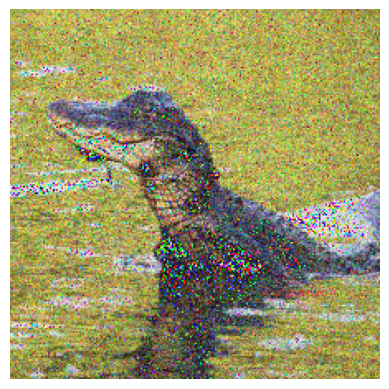

In [46]:
def noisy_input(inputs, **kwargs):

    xai_noiselevel = kwargs.pop("xai_noiselevel", 0.1)
    xai_n_noisedraws = kwargs.pop("xai_n_noisedraws", 1)
    
    device = kwargs.get("device", None)
    if not isinstance(inputs, torch.Tensor):
        inputs = torch.Tensor(inputs).to(device)

    dims = tuple(range(1, inputs.ndim))
    std = xai_noiselevel / (inputs.amax(dims, keepdim=True) - inputs.amin(dims, keepdim=True))

    result = []
    for n in range(xai_n_noisedraws):
        # the last epsilon is defined as zero to compute the true output,
        # and have SmoothGrad w/ n_iter = 1 === gradient
        if n == 0:
            epsilon = torch.zeros_like(inputs)
        else:
            epsilon = torch.randn_like(inputs) * std
            
        result.append((inputs+epsilon).detach().cpu().numpy())

    return result
    

for i, (batch, labels) in enumerate(loader):

    x_batch = batch.numpy()

    noisy_x_batches = noisy_input(x_batch, xai_noiselevel = 2.5, xai_n_noisedraws = 50)

    # Plot the data!
    for d, draw in enumerate(noisy_x_batches):
        if d <= 5:
            plot_input(draw[0], os.path.join(image_path, f"noise_{d}_inp_{0}.png"))

    break

In [37]:
xai_method = "lrp-epsilon"


result = np.zeros(x_batch.shape)
for d, draw in enumerate(noisy_x_batches):
    explanations = quantus.explain(
        model=model,
        inputs=draw,
        targets=y_batch,
        **XAI_METHOD_KWARGS[xai_method],
    )

    if d <= 5:
        plot_heatmap(explanations[0], os.path.join(image_path, f"hm_0_noise_{d}.png"), cmap="seismic", level=2.0)

    result += explanations / len(noisy_x_batches)

plot_heatmap(np.expand_dims(result[0][0], 0), os.path.join(image_path, f"hm_0_denoised.png"), cmap="seismic", level=2.0)
